In [1]:
import numpy as np
import pandas as pd

import time

import albumentations as albu
from albumentations.pytorch import ToTensor
import PIL
import cv2 as cv

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding, get_model_params

from tqdm import tqdm_notebook, tqdm

## Load the Dataset

In [2]:
# setup the input data folder
DATA_PATH = './data/'

In [3]:
# load the dataframes with labels
train_labels = pd.read_csv(DATA_PATH + 'train.csv')
test_labels = pd.read_csv(DATA_PATH + 'test.csv')
class_map = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [4]:
class_map.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [6]:
def load_images():
    '''
    Helper function to load all train and test images
    '''
    train_list = []
    for i in range(0,4):
        train_list.append(pd.read_parquet(DATA_PATH + 'train_image_data_{}.parquet'.format(i)))
    train = pd.concat(train_list, ignore_index=True)
    
    test_list = []
    for i in range(0,4):
        test_list.append(pd.read_parquet(DATA_PATH + 'test_image_data_{}.parquet'.format(i)))
    test = pd.concat(test_list, ignore_index=True)
    
    return train, test

In [7]:
train, test = load_images()

## Image Preprocessing and Augmentations

In [8]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236

def threshold_image(img):
    '''
    Helper function for thresholding the images
    '''
    gray = PIL.Image.fromarray(np.uint8(img), 'L')
    ret,th = cv.threshold(np.array(gray),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def train_transforms(p=.5):
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.RandomSizedCrop(min_max_height=(int(HEIGHT // 1.1), HEIGHT), height = HEIGHT, width = WIDTH, p=p),
        albu.Rotate(limit=5, p=p),
        albu.Resize(height = HEIGHT, width = WIDTH)
    ], p=1.0)

def valid_transforms(p=.5):
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.Resize(height = HEIGHT, width = WIDTH)
    ], p=1.0)

## Define the Dataset

Create the custom dataset:

In [9]:
def get_image(idx, df, labels):
    '''
    Helper function to get the image and label from the training set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    # get the labels
    row = labels[labels.image_id == image_id]
    labels = row['grapheme_root'].values[0], \
    row['vowel_diacritic'].values[0], \
    row['consonant_diacritic'].values[0]
    
    return img, labels

def get_validation(idx, df):
    '''
    Helper function to get the validation image and image_id from the test set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    return img, image_id

class BengaliDataset(Dataset):
    '''
    Create custom Bengali dataset
    '''
    def __init__(self, df_images, transforms, df_labels = None, validation = False):
        self.df_images = df_images
        self.df_labels = df_labels
        self.transforms = transforms
        self.validation = validation

    def __len__(self):
        return len(self.df_images)

    def __getitem__(self, idx):
        if not self.validation:
            img, label = get_image(idx, self.df_images, self.df_labels)
            img = threshold_image(img)
            aug = self.transforms(image = img)
            return TF.to_tensor(aug['image']), label
        else:
            img, image_id = get_validation(idx, self.df_images)
            img = threshold_image(img)
            aug = self.transforms(image = img)
            return TF.to_tensor(aug['image']), image_id

Try to get some images and labels from the dataset:

In [10]:
# initialize train dataset
train_dataset = BengaliDataset(train, train_transforms(), train_labels)
sample_trainloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)

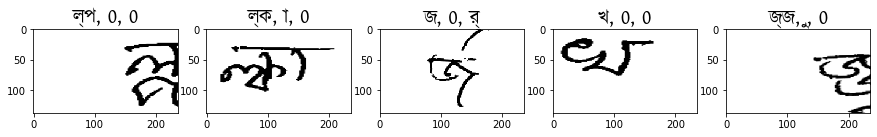

In [11]:
# plot sample train data
for img, labels in sample_trainloader:
    
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i].reshape(HEIGHT, WIDTH)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('./kalpurush.ttf')
        grapheme_root = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[i].set_title('{}, {}, {}'.format(grapheme_root, vowel_diacritic, consonant_diacritic), 
                         fontproperties=prop, fontsize=20)
    break;

## Define the Model

Load the EfficientNet model:

In [12]:
efficientnet_b0 = EfficientNet.from_name('efficientnet-b0')

In [13]:
efficientnet_b0

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [14]:
class BengaliModel(nn.Module):
    def __init__(self, backbone_model):
        super(BengaliModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)
        self.backbone_model = backbone_model
        self.fc1 = nn.Linear(in_features=1000, out_features=168) # grapheme_root
        self.fc2 = nn.Linear(in_features=1000, out_features=11) # vowel_diacritic
        self.fc3 = nn.Linear(in_features=1000, out_features=7) # consonant_diacritic
        
    def forward(self, x):
        # pass through the backbone model
        y = self.conv(x)
        y = self.backbone_model(y)
        
        # multi-output
        grapheme_root = self.fc1(y)
        vowel_diacritic = self.fc2(y)
        consonant_diacritic = self.fc3(y)
        
        return grapheme_root, vowel_diacritic, consonant_diacritic

In [15]:
model = BengaliModel(efficientnet_b0)

## Setup the Training

The hyperparameters:

In [16]:
test_split = 0.2
batch_size = 128
epochs = 10
learning_rate = 0.001
num_workers = 0

Setup the samplers:

In [17]:
dataset_size = len(train_dataset)

indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = DataLoader(train_dataset, batch_size=32, sampler=test_sampler, num_workers=num_workers)

Setup the loss function and the optimizer:

In [18]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

Setup the device:

In [19]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Initialize the dataframe to store training statistics:

In [20]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy'
                                      ,'Test loss', 'Test accuracy'])

## Train the Model

In [21]:
def get_accuracy(ps, labels):
    ps = torch.exp(ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    return accuracy

In [22]:
#train the model
model.to(device)

BengaliModel(
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (backbone_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=

In [23]:
state = torch.load('efficientnet_b0_10.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [32]:
steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in tqdm(trainloader):
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), [label.to(device) for label in labels]
        
        optimizer.zero_grad()
        
        grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
        loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + \
        criterion(consonant_diacritic, labels[2])
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        train_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0

        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), [label.to(device) for label in labels]
            
            grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
            batch_loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + criterion(consonant_diacritic, labels[2])
        
            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            test_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader),
                                      'Train accuracy': train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader),
                                      'Test accuracy': test_accuracy/len(testloader)}, ignore_index=True)

    running_loss = 0
    steps = 0
    model.train()

  0%|                                                                                         | 0/1256 [00:04<?, ?it/s]


tensor(103, device='cuda:0')
tensor([1.6317e-07, 1.2401e-08, 1.2279e-07, 3.2383e-06, 6.9693e-07, 5.6028e-07,
        1.0416e-08, 3.0722e-09, 8.9240e-07, 1.8895e-09, 3.5720e-06, 1.4759e-09,
        8.8109e-08, 1.8069e-02, 2.9577e-06, 1.9999e-04, 5.1345e-07, 1.8116e-05,
        4.0401e-03, 6.7824e-05, 6.3701e-06, 1.8464e-05, 9.1649e-06, 1.0017e-07,
        3.1475e-09, 2.4849e-10, 3.9149e-11, 1.1820e-11, 1.2393e-08, 1.5139e-06,
        2.4637e-09, 1.5556e-07, 2.9976e-03, 2.5513e-08, 1.4506e-05, 6.9476e-07,
        1.9237e-05, 4.0321e-08, 1.3482e-05, 5.2839e-06, 4.4318e-08, 2.6039e-10,
        5.8580e-07, 3.5026e-07, 2.0096e-09, 5.1190e-12, 1.7697e-04, 6.7994e-09,
        1.3286e-05, 1.8353e-06, 6.7462e-05, 4.2198e-07, 2.0025e-06, 1.4416e-06,
        2.7591e-09, 4.3612e-05, 1.1224e-07, 1.4872e-08, 2.7454e-06, 5.8878e-08,
        3.2715e-08, 8.4588e-06, 3.4529e-09, 1.4689e-09, 2.9655e-06, 8.6781e-08,
        5.3819e-08, 6.7914e-07, 6.8586e-07, 6.8837e-07, 3.7600e-07, 1.9369e-05,
        1.8

d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(101, device='cuda:0')
tensor([3.6896e-04, 2.2181e-05, 1.3807e-06, 5.1260e-06, 2.8841e-05, 6.6361e-06,
        1.8278e-06, 2.1304e-06, 3.7459e-05, 5.4679e-06, 1.0496e-06, 5.9031e-06,
        1.3152e-06, 8.3714e-04, 1.3363e-05, 9.9289e-07, 1.4900e-05, 7.9054e-06,
        6.8368e-04, 3.1101e-06, 6.9449e-05, 6.3739e-05, 2.5885e-03, 8.0838e-03,
        7.3596e-05, 3.7835e-03, 4.1654e-05, 7.3777e-04, 1.6513e-02, 1.6898e-03,
        4.9646e-05, 2.8356e-05, 2.0891e-03, 7.6388e-07, 1.3923e-06, 5.6158e-06,
        4.0772e-04, 1.3803e-06, 1.8228e-03, 2.5659e-03, 2.6470e-04, 1.2712e-05,
        3.5634e-04, 2.0315e-04, 2.5245e-04, 1.6258e-05, 6.7694e-07, 1.8699e-05,
        4.9482e-03, 4.6129e-06, 1.2315e-04, 2.6886e-05, 2.7512e-05, 9.5660e-05,
        7.4719e-07, 2.8126e-04, 2.6328e-05, 7.8499e-06, 2.5004e-05, 9.6836e-02,
        1.0832e-03, 2.0003e-04, 1.4805e-03, 7.7504e-04, 4.5324e-04, 1.8098e-05,
        2.1785e-06, 1.5918e-04, 1.7359e-05, 6.0616e-06, 2.3842e-05, 4.6018e-03,
        2.3

KeyboardInterrupt: 

Save weights and training statistics:

In [41]:
filename = 'efficientnet_b0_2' + str(epochs) + '.pth'

checkpoint = {'state_dict': model.state_dict()}

torch.save(checkpoint, filename)

In [46]:
train_stats.to_csv('train_stats_{}.csv'.format(epochs))

## Plot Training Statistics

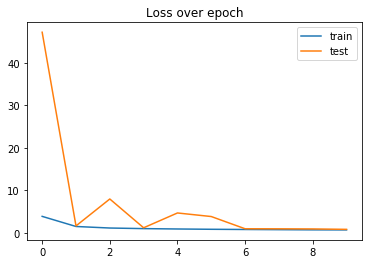

In [44]:
plt.plot(train_stats['Train loss'], label='train')
plt.plot(train_stats['Test loss'], label='test')
plt.title('Loss over epoch')
plt.legend()
plt.show()

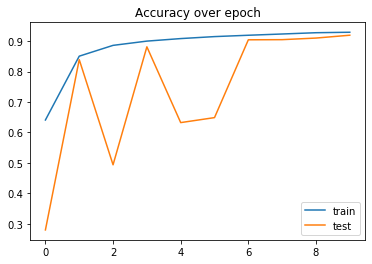

In [45]:
plt.plot(train_stats['Train accuracy'], label='train')
plt.plot(train_stats['Test accuracy'], label='test')
plt.title('Accuracy over epoch')
plt.legend()
plt.show()

## Look at Sample Predictions

d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


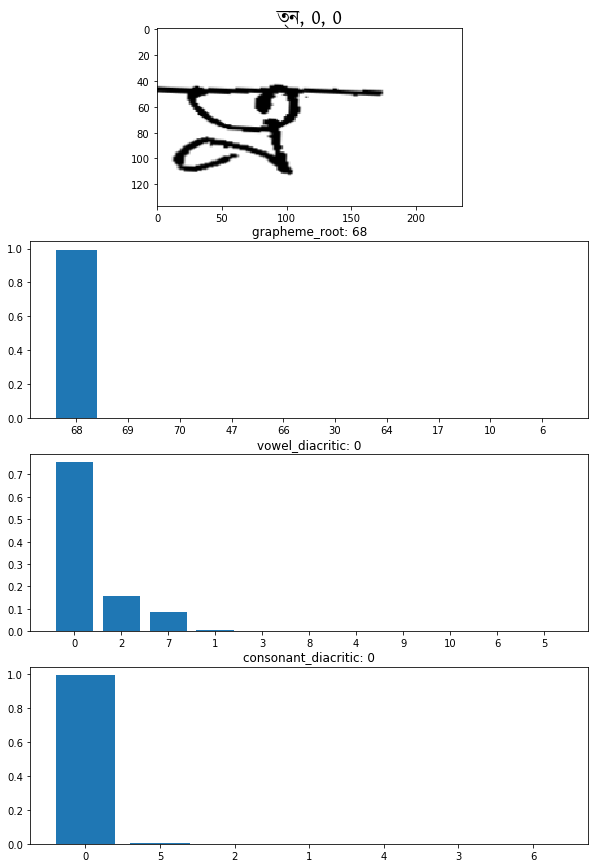

In [36]:
# plot sample train data
model.eval()
for img, labels in testloader:
    img, labels = img.to(device), [label.to(device) for label in labels]
    grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(img)
    
    img = img.cpu()
    grapheme_root = grapheme_root.cpu()
    vowel_diacritic = vowel_diacritic.cpu()
    consonant_diacritic = consonant_diacritic.cpu()
    
    # visualize the inputs
    fig, axs = plt.subplots(4, 1, figsize=(10,15))
    for i in range(0, img.shape[0]):
        axs[0].imshow(TF.to_pil_image(img[i].reshape(HEIGHT, WIDTH)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('./kalpurush.ttf')
        grapheme_root_str = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic_str = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic_str = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[0].set_title('{}, {}, {}'.format(grapheme_root_str, vowel_diacritic_str, consonant_diacritic_str), 
                         fontproperties=prop, fontsize=20)
        
        # analyze grapheme root prediction
        ps_root = F.softmax(grapheme_root[i])
        top10_p, top10_class = ps_root.topk(10, dim=0)
        
        top10_p = top10_p.detach().numpy()
        top10_class = top10_class.detach().numpy()
        
        axs[1].bar(range(len(top10_p)), top10_p)
        axs[1].set_xticks(range(len(top10_p)))
        axs[1].set_xticklabels(top10_class)
        axs[1].set_title('grapheme_root: {}'.format(labels[0][i]))
        
        # analyze vowel prediction
        ps_vowel = F.softmax(vowel_diacritic[i])
        top11_p, top11_class = ps_vowel.topk(11, dim=0)
        
        top11_p = top11_p.detach().numpy()
        top11_class = top11_class.detach().numpy()
        
        axs[2].bar(range(len(top11_p)), top11_p)
        axs[2].set_xticks(range(len(top11_p)))
        axs[2].set_xticklabels(top11_class)
        axs[2].set_title('vowel_diacritic: {}'.format(labels[1][i]))
        
        # analyze consonant prediction
        ps_cons = F.softmax(consonant_diacritic[i])
        top7_p, top7_class = ps_cons.topk(7, dim=0)
        
        top7_p = top7_p.detach().numpy()
        top7_class = top7_class.detach().numpy()
        
        axs[3].bar(range(len(top7_p)), top7_p)
        axs[3].set_xticks(range(len(top7_p)))
        axs[3].set_xticklabels(top7_class)
        axs[3].set_title('consonant_diacritic: {}'.format(labels[2][i]))
        
        plt.show()
        break;
        
    break;